<a href="https://colab.research.google.com/github/Taghr66d/MSc-SummerProject2025/blob/main/1st_code_SummerProject2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install pycbc lalsuite --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 3.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 5.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━

In [50]:
import numpy as np
import pycbc.noise
import pycbc.psd
import pycbc.waveform
import pycbc.types
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

tfd = tfp.distributions


In [51]:
sample_rate = 4096
duration = 1.0
delta_t = 1.0 / sample_rate
f_lower = 20
detectors = ['H1', 'L1', 'V1']
psd_model = lambda length: pycbc.psd.aLIGOZeroDetHighPower(length, delta_f=1/duration, low_freq_cutoff=f_lower)
num_samples = 100


In [52]:
def sample_bbh_parameters():
    mass1 = np.random.uniform(10, 50)
    mass2 = np.random.uniform(10, mass1)
    return {
        'mass1': mass1,
        'mass2': mass2,
        'distance': np.random.uniform(100, 1000),
        'inclination': np.random.uniform(0, np.pi),
        'ra': np.random.uniform(0, 2*np.pi),
        'dec': np.random.uniform(-1, 1),
        'polarization': np.random.uniform(0, 2*np.pi),
        'coa_phase': 0,
        'delta_t': delta_t,
        'f_lower': f_lower,
        'approximant': 'IMRPhenomD',
        'tc': duration / 2
    }


In [53]:
def whiten_strain(strain, psd, delta_t):
    freq_data = strain.to_frequencyseries()
    psd = np.clip(psd.numpy(), 1e-12, np.inf)
    white_freq = freq_data.numpy() / np.sqrt(psd)
    white_time = pycbc.types.FrequencySeries(white_freq, delta_f=freq_data.delta_f).to_timeseries()
    return white_time

def preprocess_sample(raw_sample):
    N = raw_sample.shape[0]
    result = []
    for i in range(3):
        ts = pycbc.types.TimeSeries(raw_sample[:, i], delta_t=delta_t)
        flen = len(ts) // 2 + 1
        psd = psd_model(flen)
        whitened = whiten_strain(ts, psd, delta_t)
        arr = whitened.numpy()
        normed = (arr - np.mean(arr)) / np.std(arr)
        result.append(normed)
    return np.stack(result, axis=-1)


In [54]:
X, y = [], []
for _ in range(num_samples):
    params = sample_bbh_parameters()
    hp, hc = pycbc.waveform.get_td_waveform(**params)
    hp = hp.time_slice(0, duration)
    hp.resize(int(sample_rate * duration))

    detectors_data = []
    for _ in range(3):
        noise = pycbc.noise.noise_from_psd(len(hp), delta_t, psd_model(len(hp) // 2 + 1))
        strain = noise + hp
        detectors_data.append(strain.numpy())

    data = np.stack(detectors_data, axis=-1)
    X.append(data)
    y.append(params)

X = np.array(X)
X_preprocessed = np.array([preprocess_sample(x) for x in X])


In [55]:
param_keys = ['mass1', 'mass2', 'distance', 'inclination', 'ra', 'dec', 'polarization']

def normalize(value, key):
    bounds = {
        'mass1': (10, 50), 'mass2': (10, 50), 'distance': (100, 1000),
        'inclination': (0, np.pi), 'ra': (0, 2*np.pi), 'dec': (-1, 1), 'polarization': (0, 2*np.pi)
    }
    vmin, vmax = bounds[key]
    normed = (value - vmin) / (vmax - vmin)
    return np.clip(normed, 1e-4, 1 - 1e-4)

y_matrix = np.array([
    [normalize(sample[k], k) for k in param_keys] * 2  # 7 × 2 = 14
    for sample in y
])


In [56]:
def make_cnn_model(input_shape=(4096, 3), num_outputs=14):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Conv1D(16, 32, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(32, 16, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Conv1D(64, 8, activation='relu', padding='same')(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(2 * num_outputs)(x)

    def split_and_clip(t):
        alpha, beta = tf.split(t, 2, axis=-1)
        alpha = tf.nn.softplus(alpha)
        beta = tf.nn.softplus(beta)
        alpha = tf.clip_by_value(alpha, 1e-3, 100.0)
        beta = tf.clip_by_value(beta, 1e-3, 100.0)
        return tf.concat([alpha, beta], axis=-1)

    outputs = layers.Lambda(split_and_clip)(x)
    return tf.keras.Model(inputs, outputs)


In [57]:
def nll_kumaraswamy(y_true, y_pred):
    D = y_true.shape[-1]
    alpha = y_pred[:, :D]
    beta = y_pred[:, D:]
    y_true = tf.clip_by_value(y_true, 1e-4, 1 - 1e-4)
    dist = tfd.Kumaraswamy(concentration1=alpha, concentration0=beta)
    return -tf.reduce_mean(dist.log_prob(y_true))


In [58]:
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y_matrix, test_size=0.1)

model = make_cnn_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss=nll_kumaraswamy)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=8
)


Epoch 1/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 322ms/step - loss: 0.0688 - val_loss: 0.0329
Epoch 2/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 265ms/step - loss: 0.0049 - val_loss: 0.0238
Epoch 3/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 343ms/step - loss: -0.0054 - val_loss: 0.0114
Epoch 4/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - loss: -0.0266 - val_loss: 0.0054
Epoch 5/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - loss: -0.0218 - val_loss: 0.0018
Epoch 6/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - loss: -0.0178 - val_loss: -9.2164e-04
Epoch 7/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: -0.0293 - val_loss: -0.0086
Epoch 8/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - loss: -0.0421 - val_loss: -0.0164


In [59]:
idx = 0  # Choose a sample
x_test = X_preprocessed[idx:idx+1]  # shape (1, 4096, 3)
y_true = y_matrix[idx]  # normalized true values


In [60]:
pred = model.predict(x_test)
alpha = pred[0, :14]
beta = pred[0, 14:]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


In [61]:
dist = tfd.Kumaraswamy(concentration1=alpha, concentration0=beta)
samples = dist.sample(1000).numpy()  # shape: (1000, 14)


In [62]:
param_keys = ['mass1', 'mass2', 'distance', 'inclination', 'ra', 'dec', 'polarization']

def denormalize(normed, key):
    bounds = {
        'mass1': (10, 50), 'mass2': (10, 50), 'distance': (100, 1000),
        'inclination': (0, np.pi), 'ra': (0, 2*np.pi), 'dec': (-1, 1), 'polarization': (0, 2*np.pi)
    }
    vmin, vmax = bounds[key]
    return normed * (vmax - vmin) + vmin

# De-normalize only first 7 dimensions
physical_samples = {
    key: denormalize(samples[:, i], key)
    for i, key in enumerate(param_keys)
}


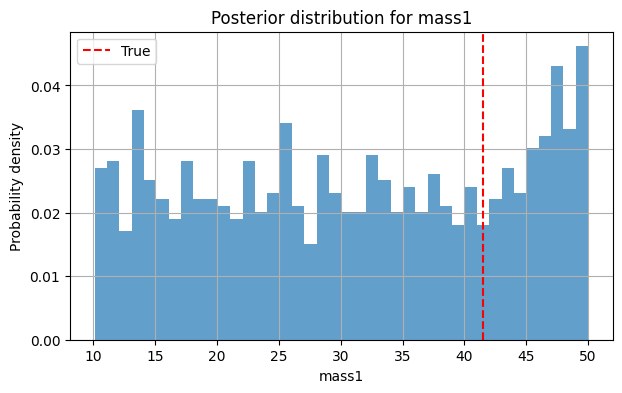

In [63]:
import matplotlib.pyplot as plt

param = "mass1"

plt.figure(figsize=(7, 4))
plt.hist(physical_samples[param], bins=40, density=True, alpha=0.7)
plt.axvline(denormalize(y_true[0], param), color='red', linestyle='--', label='True')
plt.title(f"Posterior distribution for {param}")
plt.xlabel(param)
plt.ylabel("Probability density")
plt.legend()
plt.grid(True)
plt.show()


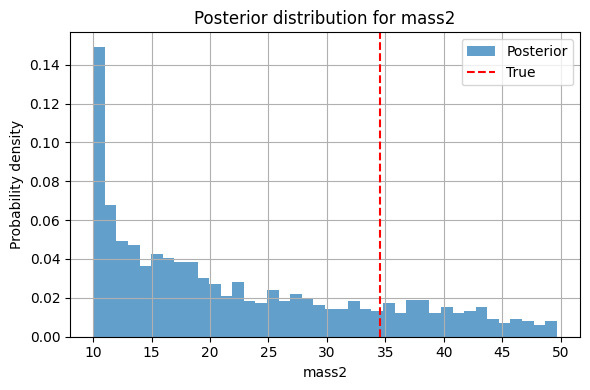

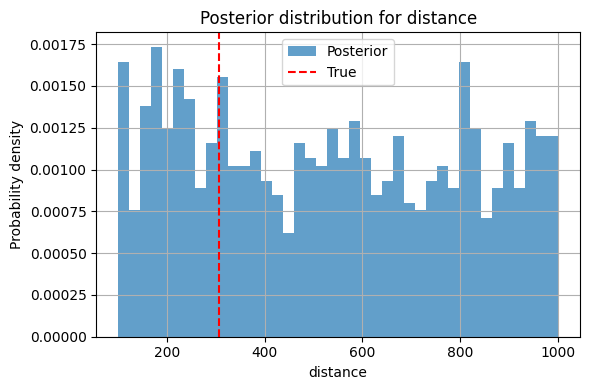

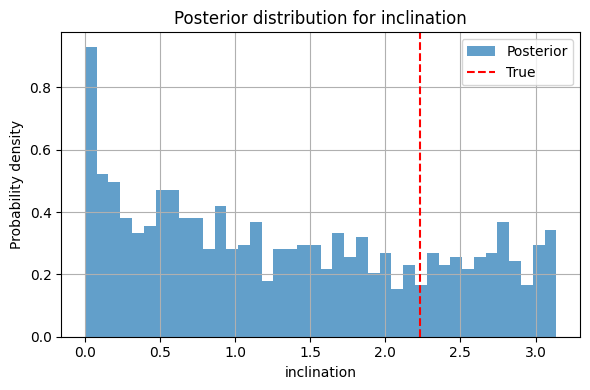

In [64]:
# Choose parameters to visualize
params_to_plot = ["mass2", "distance", "inclination"]

for i, param in enumerate(params_to_plot):
    plt.figure(figsize=(6, 4))

    # Index of the param in the normalized label list
    idx = param_keys.index(param)

    # De-normalize the 1000 samples
    values = denormalize(samples[:, idx], param)

    # Plot
    plt.hist(values, bins=40, density=True, alpha=0.7, label='Posterior')
    plt.axvline(denormalize(y_true[idx], param), color='red', linestyle='--', label='True')

    plt.title(f"Posterior distribution for {param}")
    plt.xlabel(param)
    plt.ylabel("Probability density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [65]:
!pip install corner --quiet


In [66]:
import corner

# Select parameters you want to include in the corner plot
param_subset = ['mass1', 'mass2', 'distance', 'inclination']

# Extract their indices and denormalize
sample_subset = np.stack([
    denormalize(samples[:, param_keys.index(k)], k)
    for k in param_subset
], axis=1)

# Get true values for comparison
truths = [denormalize(y_true[param_keys.index(k)], k) for k in param_subset]


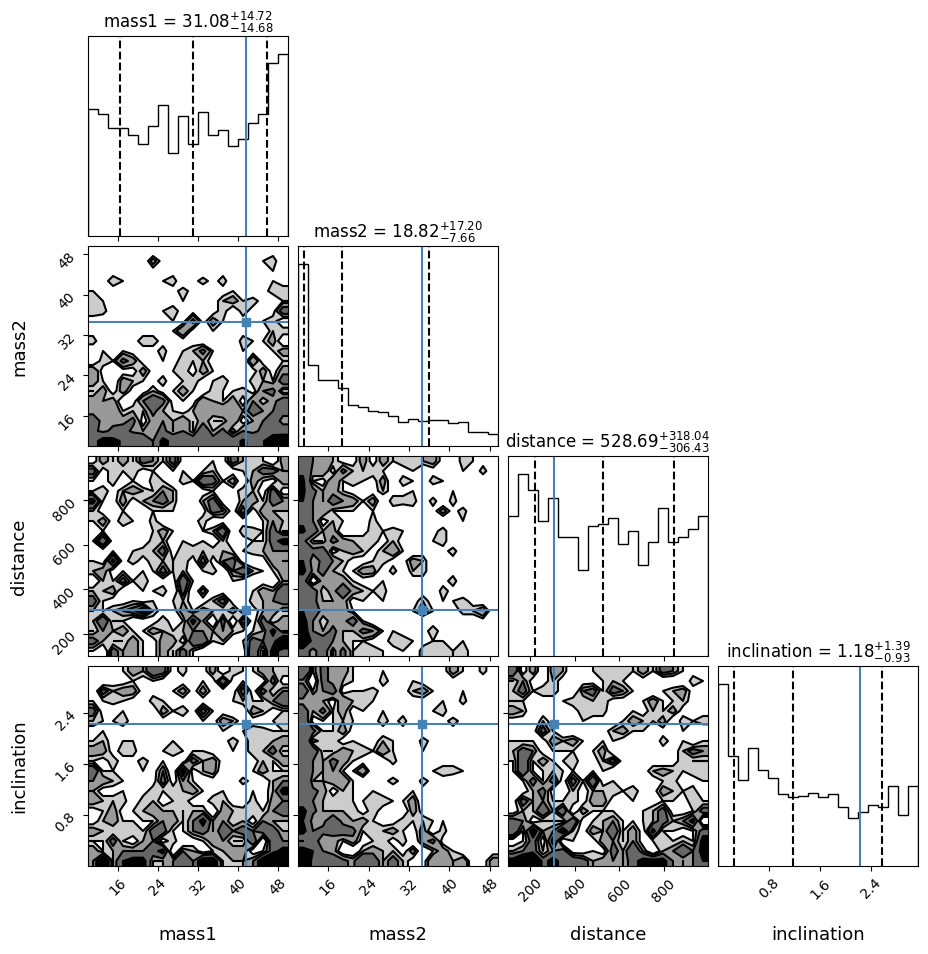

In [67]:
figure = corner.corner(
    sample_subset,
    labels=param_subset,
    truths=truths,
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 13},
    quantiles=[0.16, 0.5, 0.84],
    plot_datapoints=False,
    fill_contours=True
)


In [68]:
# Choose several test samples (for example, 10)
test_indices = np.arange(len(X_val))[:10]  # use first 10 of validation set
n_post_samples = 1000

all_samples = []
all_truths = []

for idx in test_indices:
    x = X_val[idx:idx+1]
    true_norm = y_val[idx]

    pred = model.predict(x)
    alpha = pred[0, :14]
    beta = pred[0, 14:]
    dist = tfd.Kumaraswamy(alpha, beta)

    samples_norm = dist.sample(n_post_samples).numpy()  # shape (1000,14)
    all_samples.append(samples_norm)
    all_truths.append(true_norm)

all_samples = np.array(all_samples)  # shape (num_tests, n_post, 14)
all_truths = np.array(all_truths)    # shape (num_tests, 14)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


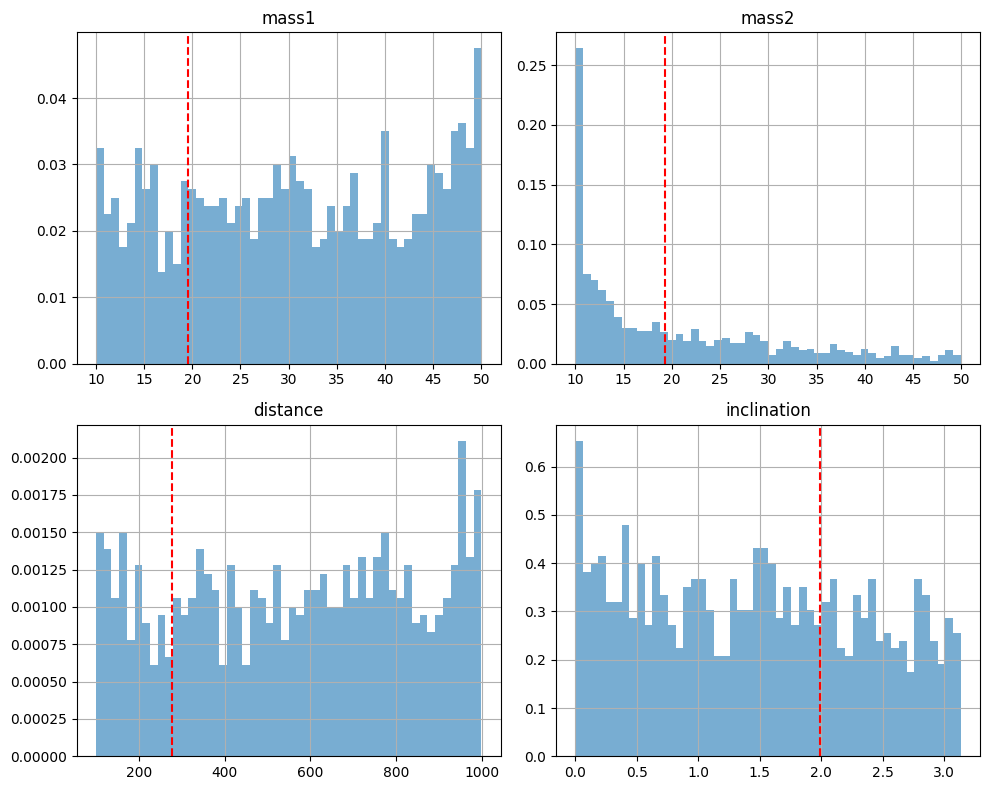

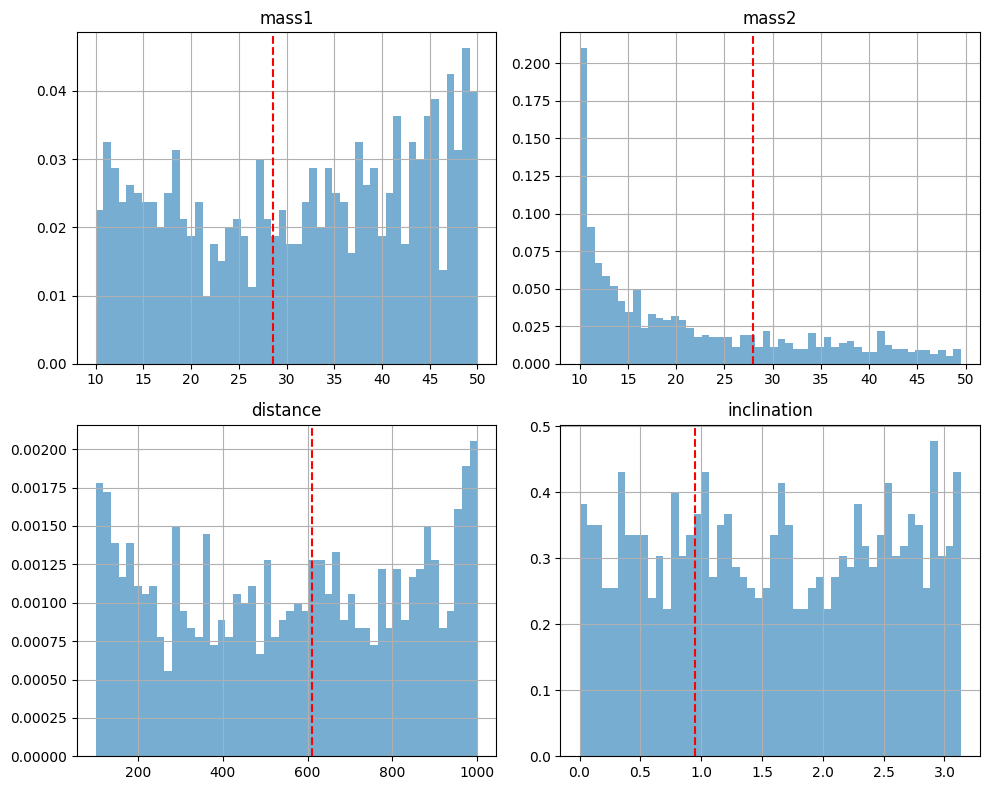

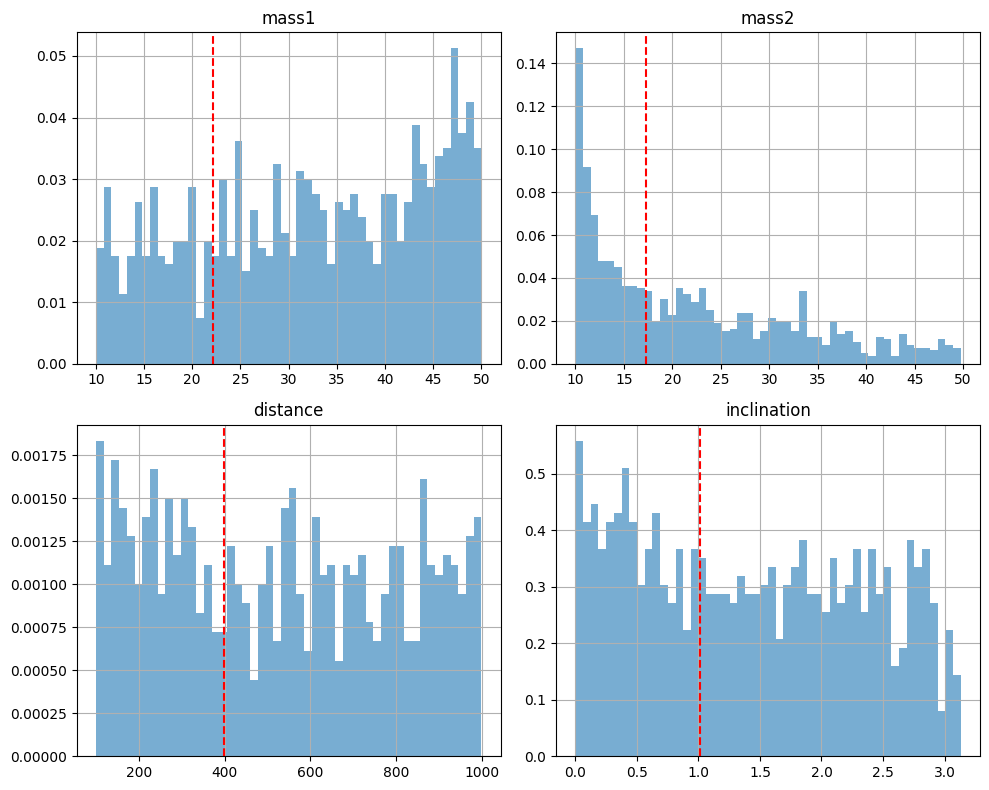

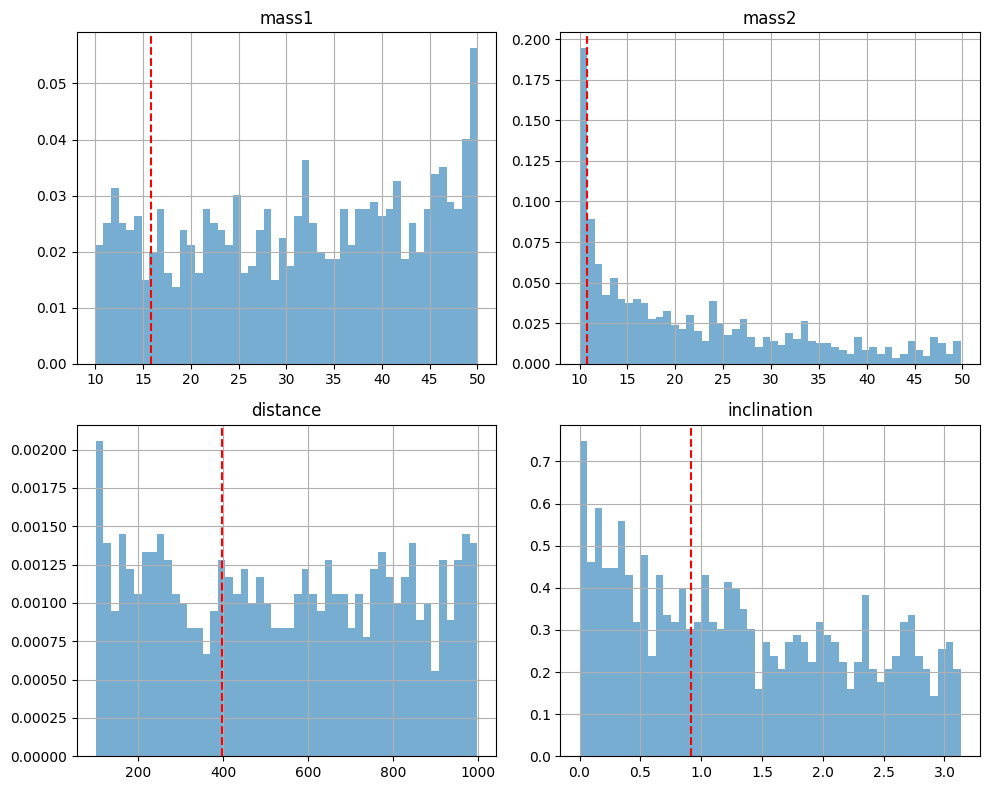

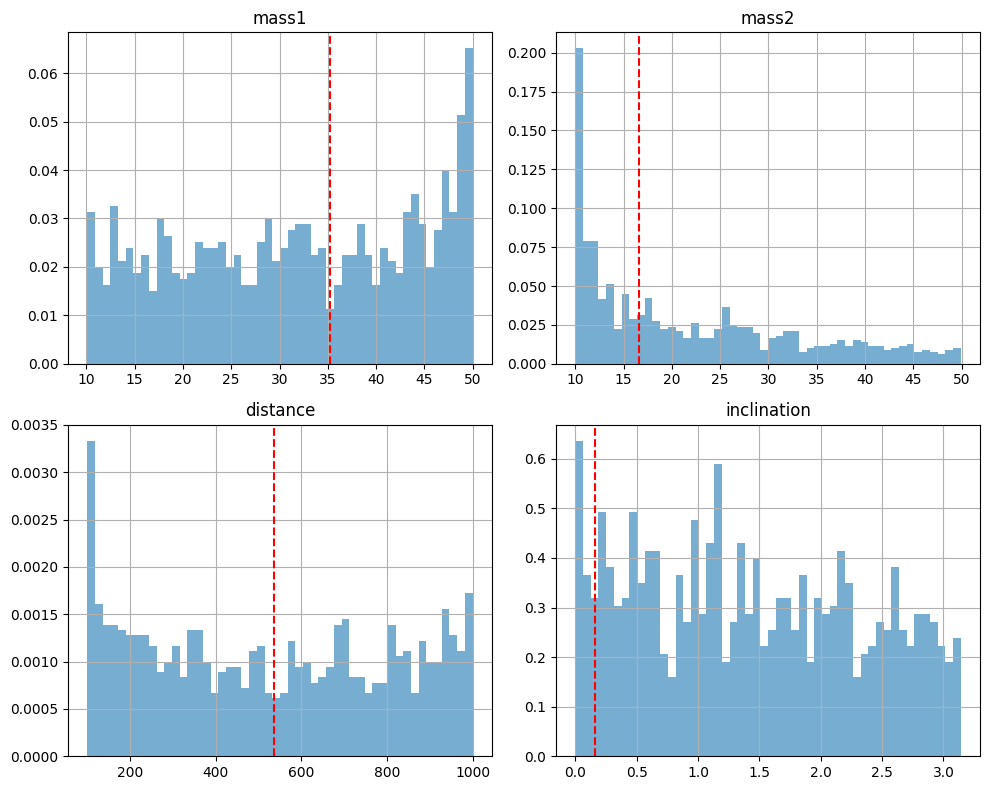

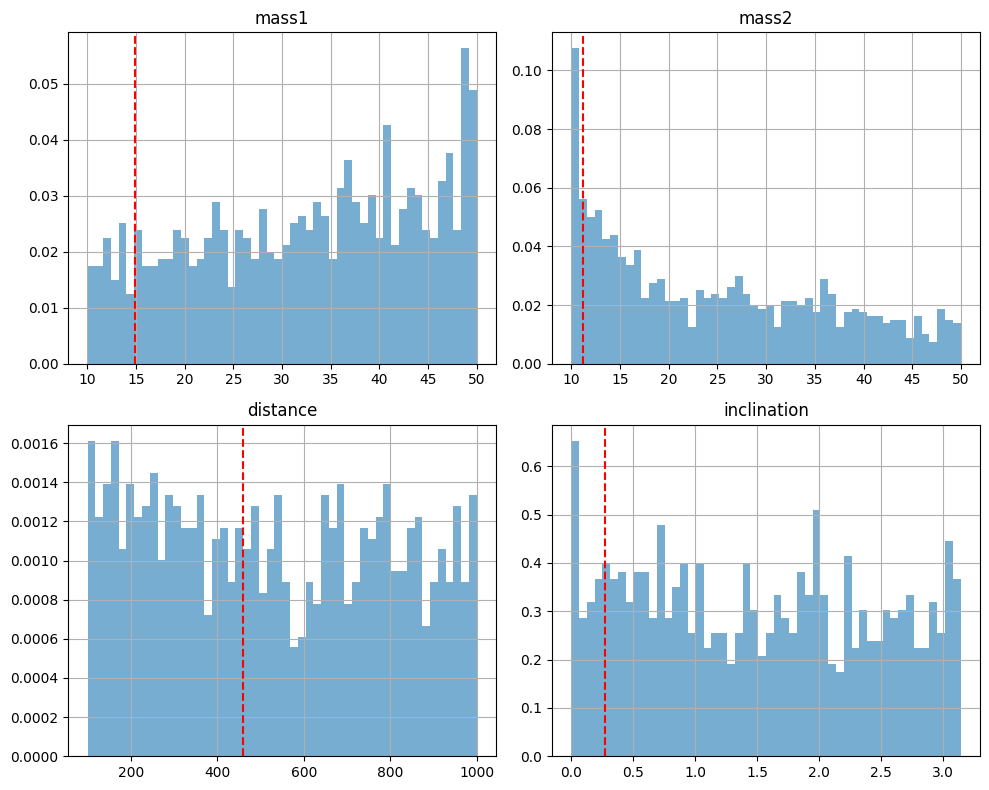

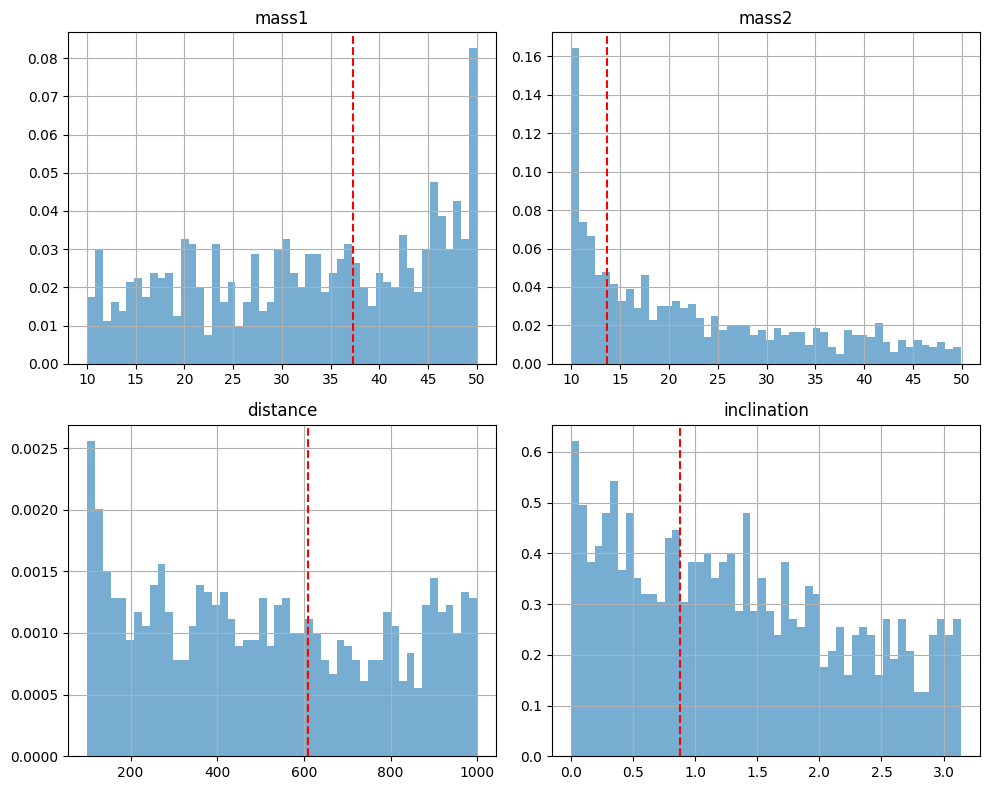

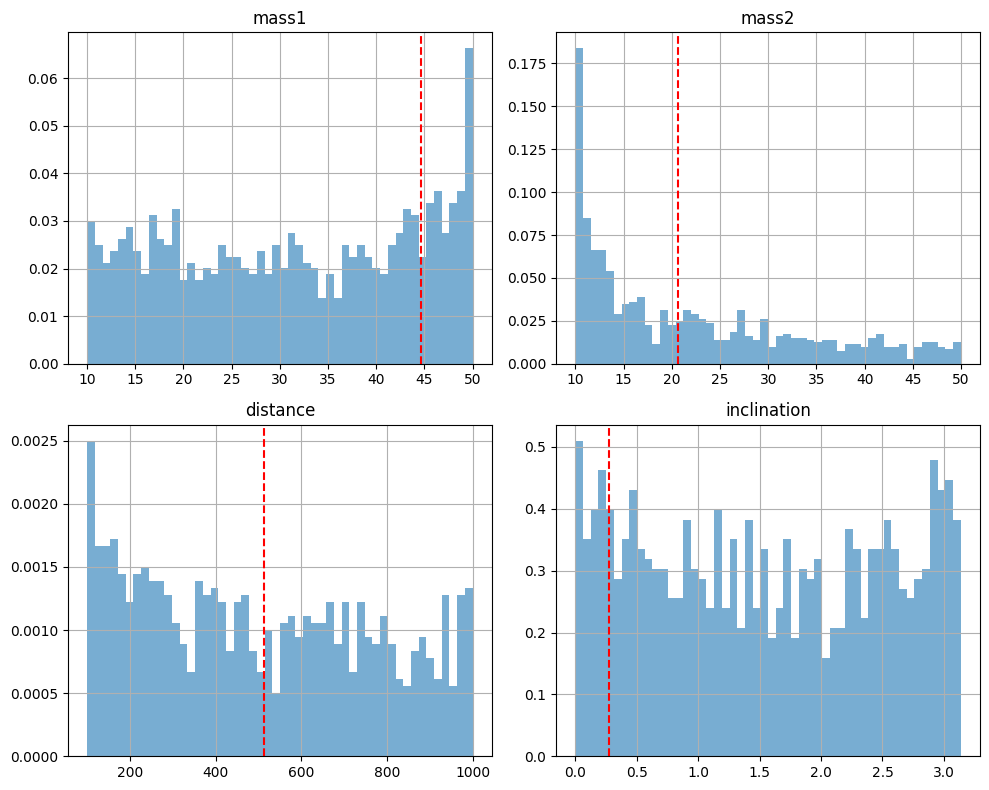

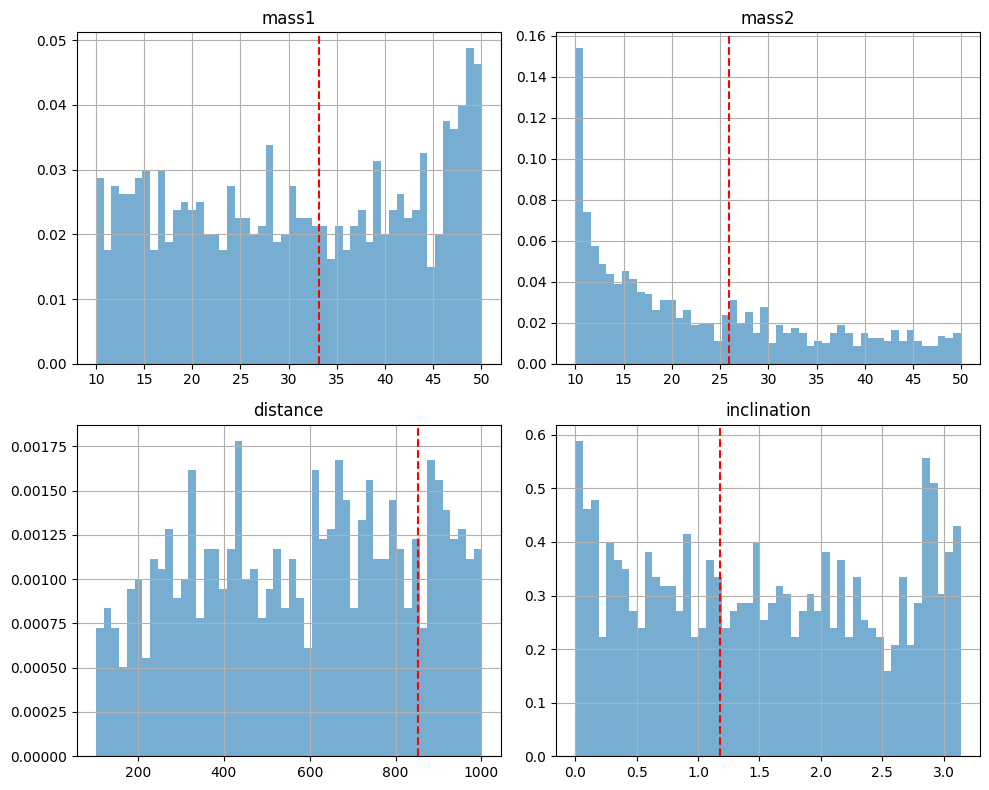

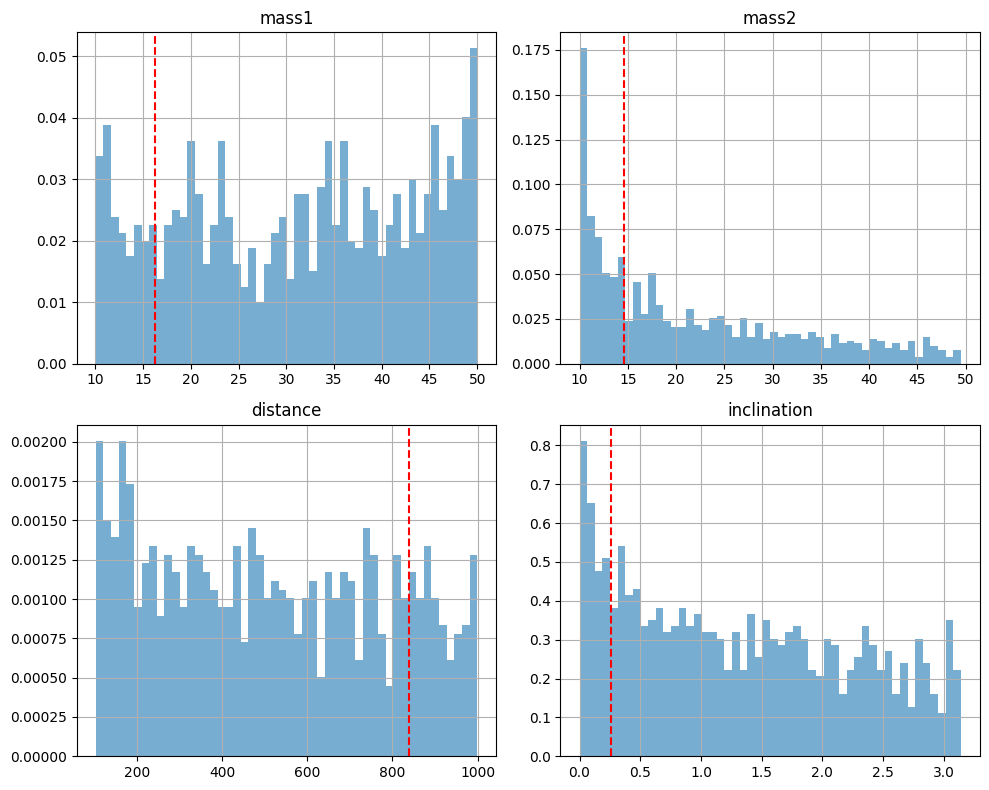

In [69]:
selected_params = ['mass1', 'mass2', 'distance', 'inclination']

for i in range(len(test_indices)):
    samples_norm = all_samples[i]
    truths_norm = all_truths[i]

    plt.figure(figsize=(10, 8))
    for j, param in enumerate(selected_params):
        idx_p = param_keys.index(param)
        # Denormalize
        s = denormalize(samples_norm[:, idx_p], param)
        t = denormalize(truths_norm[idx_p], param)

        plt.subplot(2, 2, j+1)
        plt.hist(s, bins=50, density=True, alpha=0.6)
        plt.axvline(t, color='r', linestyle='--')
        plt.title(param)
        plt.grid(True)
    plt.tight_layout()
    plt.show()


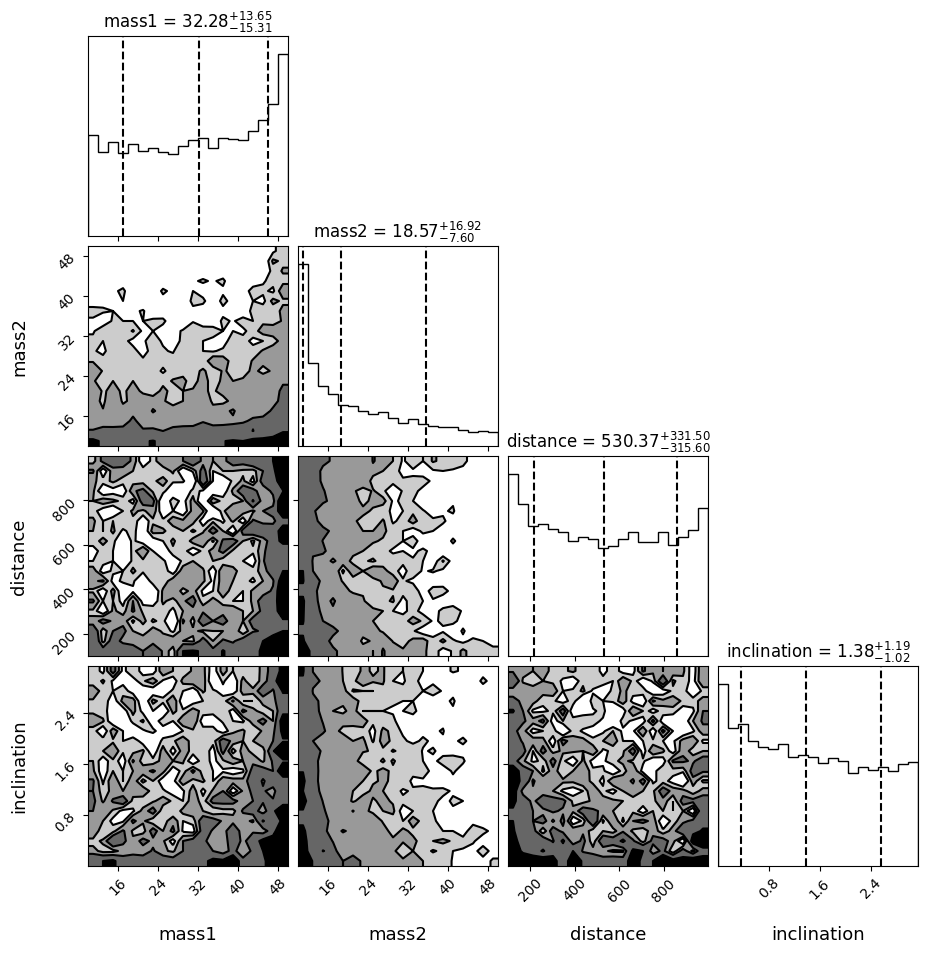

In [70]:
import corner

# Stack across tests: reshape to (n_tests * n_post_samples, 7)
stacked = all_samples.reshape(-1, all_samples.shape[-1])

subset = ['mass1','mass2','distance','inclination']
idxs = [param_keys.index(p) for p in subset]

stacked_phys = np.stack([denormalize(stacked[:, i], p) for i, p in zip(idxs, subset)], axis=1)

corner.corner(stacked_phys, labels=subset, show_titles=True, quantiles=[0.16,0.5,0.84],
              title_fmt=".2f", title_kwargs={"fontsize": 12}, label_kwargs={"fontsize": 13},
              plot_datapoints=False, fill_contours=True)
plt.show()


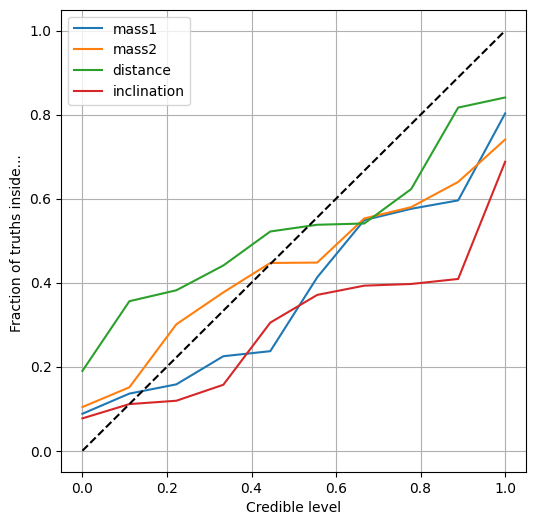

In [71]:
def pp_plot(all_samples, all_truths, param):
    idx = param_keys.index(param)
    norms = all_truths[:, idx]
    samples = all_samples[:, :, idx]

    percentiles = [np.mean(s < norm) for s, norm in zip(samples, norms)]
    sorted_pct = np.sort(percentiles)
    N = len(sorted_pct)
    plt.plot(np.linspace(0,1,N), sorted_pct, label=param)

plt.figure(figsize=(6,6))
for param in selected_params:
    pp_plot(all_samples, all_truths, param)
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('Credible level')
plt.ylabel('Fraction of truths inside... ')
plt.legend()
plt.grid(True)
plt.show()


In [72]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=8,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - loss: -0.0519 - val_loss: -0.0181
Epoch 2/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: -0.0422 - val_loss: -0.0143
Epoch 3/8
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - loss: -0.0466 - val_loss: -0.0159


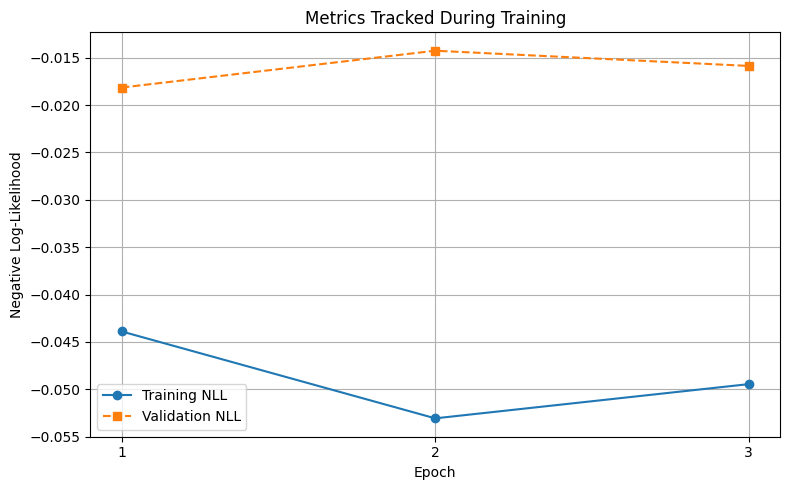

In [73]:
import matplotlib.pyplot as plt

epochs = range(1, len(history.history['loss']) + 1)
train_losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, 'o-', color='tab:blue', label='Training NLL')
plt.plot(epochs, val_losses, 's--', color='tab:orange', label='Validation NLL')

plt.title('Metrics Tracked During Training')
plt.xlabel('Epoch')
plt.ylabel('Negative Log‑Likelihood')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
